We're gonna have some basic setup before we get to the focus.
Here we define the models and make a couple auxiliary functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Defining linear and logistic models
def linear(x, slope, intercept):
    return slope*x + intercept

def logit(p):
    return np.log(p/(1-p))

def inv_logit(alpha):
    return np.exp(alpha)/(np.exp(alpha)+1)

def logistic(x, beta_0, beta_1):
    return inv_logit(linear(x, beta_0, beta_1))



In [2]:
# Calculate the gradient of vector feld f at v
def gradient(f, v):
    differential_length: float = 2**-16 # this can be adjusted

    n = len(v)
    grad = np.zeros(n)

    # I wonder if numpy has a better way to do this?
    for i in range(len(v)):
        d = np.zeros(n)
        d[i] = differential_length
        directional_derivative = (f(v+d/2) - f(v-d/2))/differential_length
        grad[i] = directional_derivative
    return grad

And here are parameters to decide what model we're using. **Edit this section** if you want to test with a different model.

In [3]:
# These can be changed to run different tests
# You need to change the loss function below also
model = linear
step_size = 2**-12
epoch_count = 2**14

# This gets the parameter count of the model
# (Which is one less than the number of arguments that model takes, since one of the arguments is the input vector)
import inspect
param_count = len(inspect.signature(model).parameters) - 1

In [4]:
# Defining the loss function
def squared_error(params, x, y):
    squared_error = (model(x, *params) - y)**2
    return squared_error

def log_loss(params, x, y):
    prob = model(x, *params)
    if y:
        return -np.log(prob)
    else:
        return -np.log(1-prob)

def mean_loss(pointwise_loss):
    def f(params, xdata, ydata, weights = None):
        n = len(xdata)
        if weights is None:
            weights = [1] * n
        losses = [pointwise_loss(params, xdata[i], ydata[i])*weights[i] for i in range(n)]
        return sum(losses)/n
    return f


default_loss = mean_loss(squared_error)

In [5]:

# These determine the training data
xdata = np.array([0, 1, 2])
ydata = np.array([0, 1.5, 2])

Here's the code for training the model using gradient descent:

In [6]:
def gradient_descent(params, xdata, ydata, weights = None, loss = default_loss):
    f = lambda theta: loss(theta, xdata, ydata, weights)
    for _ in range(epoch_count):
        grad = gradient(f, params)
        params -= grad*step_size
    return params

This is the response function.
The response function calculates the parameters which result from retraining with an additional datapoint *new* that is weighted by some amount *epsilon*.

In [7]:
# Influence functions are defined as the first-order Taylor approximation of this around epsilon = 0
# Or maybe the derivative if it's more convenient to subtract off the value at 0, I think I've seen both definitions
def response_function(new_data, epsilon, xdata, ydata, loss = default_loss):
    newxdata = np.concatenate((np.array([new_data[0]]), xdata))
    newydata = np.concatenate((np.array([new_data[1]]), ydata))
    weights = np.array([epsilon] + [1 for _ in xdata])
    params = gradient_descent(np.zeros(param_count), newxdata, newydata, weights, loss)
    return params

Here's the influence function (on the parameters). It's the derivative of the response function.

In [8]:
def influence(z, epsilon, rf = response_function):
    a = rf(z, epsilon/2, xdata, ydata)
    b = rf(z, -epsilon/2, xdata, ydata)
    return (a-b)/epsilon

This takes training data and creates a model. It then calculates the influence of each point in the training data on the model, and plots the estimated result of doubling the weighting of any of the training data points.

Initial model: [0.95079561 0.23493319]
Influence of (0, 0): [ 0.11785664 -0.19758067]
Influence of (1, 1.5): [0.00653221 0.09485577]
Influence of (2, 2): [-0.04193561 -0.01165957]


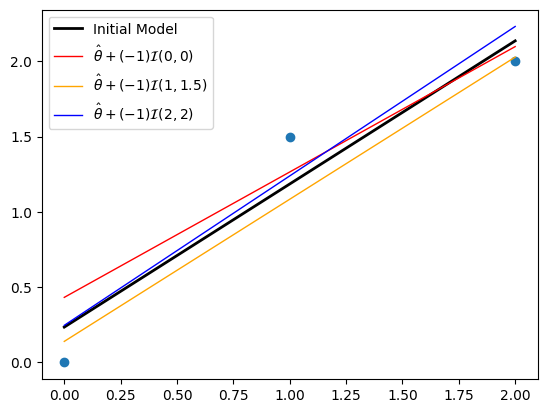

In [13]:
colors = ['red', 'orange', 'blue', 'green', 'purple', 'cyan', 'magenta', 'darkorange', 'lime', 'slateblue', 'darkkhaki', 'seagreen']

# epsilon is the step used when calculating the influence
epsilon = 0.001
# delta is the amount the model is adjusted in the direction of one of the influences for the plots
# Setting delta to 1 doubles the weighting, setting it to -1 sets the weighting to 0.
delta = -1

# Z is the training data
Z = [(0,0), (1,1.5), (2,2)]
n = len(Z)

# This code all makes the plot
M0 = response_function(Z[0], 0, xdata, ydata)
print(f'Initial model: {M0}')
influences = np.array([influence(z, epsilon) for z in Z])

for i in range(n):
    print(f'Influence of {Z[i]}: {influences[i]}')

linspace = np.linspace(xdata.min(), xdata.max(), 500)

responses = M0 + influences*delta

plt.plot(linspace, model(linspace, *M0), color='black',linewidth=2, label="Initial Model")
for i in range(n):
    plt.plot(linspace, model(linspace, *responses[i]), color=colors[i], linewidth=1, label=f"$\hat\\theta + ({delta})\mathcal{{I}}{Z[i]}$")


plt.scatter(xdata,ydata)
plt.legend()
plt.show()

In [14]:
# Calculates the influence of z1 on the loss on z2
# This is a directional derivative of loss on z2 in the direction of the influence of z1 
def loss_influence(params, z1, z2, epsilon):
    point_loss = lambda theta: default_loss(theta, z2[0], z2[1])
    grad = gradient(point_loss, params)
    return np.dot(grad, influence(z1, epsilon))

print(loss_influence(M0, (0,0), (1,0), epsilon))

data = [(0, 0), (1, 1.5), (2, 2)]

for i in range(3):
    for j in range(3):
        print(f'Cost Influence of {data[i]} on {data[j]}:')
        print(loss_influence(M0, data[i], data[j], epsilon))

-0.13120544192640377
Cost Influence of (0, 0) on (0, 0):
-0.04716392861213299
Cost Influence of (0, 0) on (1, 1.5):
0.0374848913334374
Cost Influence of (0, 0) on (2, 2):
0.009495262163364715
Cost Influence of (1, 1.5) on (0, 0):
0.03702740217143974
Cost Influence of (1, 1.5) on (1, 1.5):
-0.07386963571736015
Cost Influence of (1, 1.5) on (2, 2):
0.03685298276811481
Cost Influence of (2, 2) on (0, 0):
0.009103179214047272
Cost Influence of (2, 2) on (1, 1.5):
0.03687138332158968
Cost Influence of (2, 2) on (2, 2):
-0.04580656857786415


PBRF

In [35]:
# Given a function F:Theta->R and points p, q in Theta,
# the Bregman divergence gives the difference between F(p)
# and the first-order taylor approximation of F(p) around q
def bregman_divergence(F, p, q):
    d: float = 2**-16 # This can be changed if we need more precision

    dist = np.linalg.norm(p-q)
    dir = (p-q) / dist

    dx = dir*d
    dir_derivative = (F(q+dx/2)-F(q-dx/2))/d

    return F(p) - (F(q) + dir_derivative*dist)

final_params = np.array([1, 2])

# This is just directly copied from the Anthropic paper's
# definition of the proximal Bregman objective.
def proximal_bregman_objective(params, xdata, ydata, new_data, epsilon):
    damping: float = 2**-8 # "lambda" is a reserved code word :|
    N = len(xdata)

    term1 = 0
    for i in range(N):
        Li = lambda params: default_loss(params, xdata, ydata)
        term1 += bregman_divergence(Li, params, final_params)
    term1 /= N

    term2 = epsilon * default_loss(params, new_data[0], new_data[1])
    term3 = (damping/2) * np.linalg.norm(params - final_params)

    return term1 + term2 + term3

def pbrf(new_data, epsilon, xdata, ydata):
    newxdata = np.concatenate((np.array([new_data[0]]), xdata))
    newydata = np.concatenate((np.array([new_data[1]]), ydata))
    weights = np.array([epsilon] + [1 for _ in xdata])
    f = lambda params, xdata, ydata, weights: proximal_bregman_objective(params, xdata, ydata, new_data, epsilon)
    params = gradient_descent(np.zeros(param_count), newxdata, newydata, weights, f)
    return params

print(pbrf(z1, 1, xdata, ydata))

TypeError: object of type 'numpy.int32' has no len()